# 1. Setup

In [1]:
!pwd

/home/umni2/a/umnilab/users/verma99/mk/spr_4711/code


In [2]:
from mobilkit.umni import *
from project import *

In [3]:
import contextily as ctx

## 1.1. Load data

### 1.1.1. Zones (TIGER)

In [4]:
zones = gpd.read_parquet('../data/zones/zones2010.parquet').set_crs(CRS_DEG).disp(0)

6,417 rows x 7 cols; Memory: 1.7 MiB; CRS: EPSG:4326


,geoid,scale,county,cbsa,aland,awater,geometry
,<object>,<object>,<object>,<object>,<int64>,<int64>,<geometry>


### 1.1.2. Census (ACS)

In [5]:
acs = pd.read_csv('../data/acs/acs2019.csv').astype({'geoid': str}).disp(0)

6,407 rows x 25 cols; Memory: 1.9 MiB


,scale,geoid,popu,pop_density,p_minor,p_poc,p_lowedu,m_income,p_pov,p_pov150,p_pov200,p_snap,p_unemploy,p_noinsur,p_disabled,p_lowenglish,p_snglparent,p_crowded,p_renter,p_mobilehome,p_noveh,m_hhperveh,p_nowfh,p_transit,p_walkbike
,<object>,<object>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>


### 1.1.3. POIs (SafeGraph)

In [6]:
pois = gpd.read_parquet('../data/pois/sg_pois.parquet').set_crs(CRS_DEG).disp(0)

80,741 rows x 7 cols; Memory: 18.0 MiB; CRS: EPSG:4326


,id,purpose,category,geometry,visits,visitors,area_sqft
,<object>,<object>,<object>,<geometry>,<int32>,<int32>,<float64>


### 1.1.4. OD distances

In [7]:
od = []
for f in Path('../data/distance').glob('*.csv'):
    scale, mode, day_type = f.stem.split('.')[0].split('__')
    if day_type == 'weekend': continue
    df = pd.read_csv(f).assign(scale=scale.upper(), mode=mode.upper())
    od.append(df.assign(time=df.time / 60)) # convert to minutes
od = pd.concat(od).drop(columns=['ok', 'speed']).reset_index(drop=True)
od = od.dropna().astype({'scale': CAT, 'mode': CAT}).disp()

7,004,168 rows x 6 cols; Memory: 280.5 MiB


,src_geoid,trg_geoid,dist,time,scale,mode
,<int64>,<int64>,<float64>,<float64>,<category>,<category>
35,18105001304,18105001301,4480.0,54.466667,TRACT,TRANSIT


# 2. Accessibility measure

## 2.1. Impedance function

In [15]:
imped_params = (pd.read_csv('../data/nhts/fitted-params-power-exponential.csv')
                .assign(mode=lambda df: df['mode'].str.upper())
                .assign(measure=lambda df: df['measure'].map(
                    {'Duration': 'TIME', 'Distance': 'DIST'}))).disp()

117 rows x 5 cols; Memory: 0.0 MiB


,measure,mode,purpose,parameter,value
,<object>,<object>,<object>,<object>,<float64>
0,TIME,BIKE,Overall,alpha,0.025914


In [19]:
# def impedance(x: pd.Series, mode: str, purpose: str, params=imped_params):
#     """Impedance function for accessibility calculation."""
#     return params.query(f'mode=="{mode}" and purpose=="{purpose}"')
#     return x

# impedance(1, 'Walk', 'Overall')

## 2.2. POI importance weighting

In [12]:
def get_poi_weights(pois, method, log=True, eps=1e-6):
    """
    The method for weighting POIs (not every POI is created equal).
    Inputs:
        - pois: DataFrame containing info for each POI
        - method: One of the different ways of weighting POIs
        - log: Whether log-transform columns to reduce skewing of result
    Output:
        - the input DataFrame with an additional POI weights column
    """
    pois = pois.fillna(0) # to ensure no POI weight is NaN
    if log:
        for col in ['area_sqft', 'visits', 'visitors']:
            pois[col] = np.log10(1 + pois[col])
    weights = {
        'COUNT': 1,
        'VISITS': pois['visits'],
        'VISITORS': pois['visitors'],
        'AREA': pois['area_sqft'],
        'AREA_X_VISITS': pois['area_sqft'] * pois['visits'],
        'VISIT_DENSITY': pois['visits'] / (pois['area_sqft'] + eps),
        'VISITOR_DENSITY': pois['visitors'] / (pois['area_sqft'] + eps)
    }[method]
    return pois.assign(weight=weights)

## 2.3. Competition effect
This is the controversial inclusion of (weighted) population in the denominator of the attractiveness (facility ratio) in the E2SFCA calculation.

In [13]:
def get_popu_weights(zones, od):
    """
    Inputs:
        - zones: Zones containing population information
        - od: Table containing travel time cost for each OD pair
    """
    popu = zones.set_index('geoid')['popu'].reset_index()
    od = od.merge(popu, left_on='src_geoid', right_on='geoid')
    od['wtd_popu'] = od['cost'] * od['popu']
    weights = od.groupby('trg_geoid')['wtd_popu'].sum().rename_axis('geoid')
    return weights

## 2.4. Compute accessibility

In [40]:
imped_params.measure

,measure,mode,purpose,parameter,value
0,TIME,BIKE,Overall,alpha,0.025914
1,TIME,BIKE,Other,alpha,0.044686
2,TIME,BIKE,Shopping,alpha,0.009408
3,TIME,BIKE,Social/Recreational,alpha,0.030631
4,TIME,BIKE,Work,alpha,0.008696
...,...,...,...,...,...
112,DIST,WALK,Overall,r2,0.999945
113,DIST,WALK,Other,r2,0.999820
114,DIST,WALK,Shopping,r2,0.997407
115,DIST,WALK,Social/Recreational,r2,0.999584


In [41]:
def get_poi_access(scale: str, mode: str, purpose: str, category: str,
                   measure: str, thresh: float, decay_weight: bool,
                   zones=zones, acs=acs, pois=pois, od=od,
                   imped_params=imped_params, poi_weighting='COUNT'):
    """
    Get POI accessibility using the gravity-like E2SFCA metric.
    Inputs:
        - scale: Scale of operation
        - mode: Travel mode (currently supports only DRIVE & WALK)
        - tt_thresh: Travel time threshold (minutes)
        - zones: Table of zones for all scales
        - acs: ACS data table for all zones having at least population
        - pois: Table of POIs containing at least POI category & other 
            attributes (such as area or visits) for computing weight
        - od: Table of travel time for all OD pairs
        - poi_weight_method: One of the methods used to weight POIs
        - source_popu: Whether divide the final accessibility of 
            a zone by its population
        - target_popu: Whether divide the destination zone's 
            attractiveness by its catchment population
    """
    assert purpose in pois['purpose'].unique(), purpose
    assert category in set(pois['category'].unique()) | {'Overall'}, category
    assert measure in imped_params['measure'].unique(), measure
    # filter zones & add population data for the given scale
    acs = acs[acs['scale'] == scale][['geoid', 'popu']]
    zones = zones[zones['scale'] == scale][['geoid', 'geometry']]
    zones = zones.merge(acs, on='geoid')
    ## Destination attractiveness
    if purpose == 'Work':
        return
    else:
        # filter POIs for the given purpose
        pois = pois[pois.purpose == purpose]
        # filter POIs for the given category
        if category != 'Overall':
            pois = pois[pois.category == category]
        # get weight of each POI
        pois = get_poi_weights(pois, poi_weighting)
        # get attractiveness of each zone for each POI category
        attract = (zones.sjoin(pois)
                   .groupby(['geoid', 'purpose', 'category'])
                   ['weight'].sum().rename('attractiveness').reset_index())
    ## Impedance weight
    # filter travel times for given mode & scale
    od = od[(od['scale'] == scale) & (od['mode'] == mode)]
    # filter zones with measure values under given threshold
    od = od.rename(columns={measure: 'deterrence'})
    od = od[od['deterrence'] <= thresh]
    return od
    # od = od.query('scale=="{}" & mode=="{}" & time<={}'.format(
    #     scale, mode, tt_max)).reset_index(drop=True)
    # assign travel time-based cost to each OD pair for the given mode
    od['cost'] = {'DRIVE': get_cost_drive,
                  'WALK': get_cost_walk
                 }[mode](od['time'])
    od = od.astype({'src_geoid': str, 'trg_geoid': str})
    od = od[['src_geoid', 'trg_geoid', 'cost']]
    # if needed, update the destinations' attractiveness by 
    # dividing by the weighted population
    if target_popu:
        popu_wts = get_popu_weights(zones, od)
        attract = attract.merge(popu_wts, on='geoid')
        attract['poi_wt'] /= (attract.pop('wtd_popu') / 1e6)
    # accessibility = cost-weighted sum of destinations' attractiveness
    od = od.merge(attract, left_on='trg_geoid', right_on='geoid')
    od['access'] = od['poi_wt'] * od['cost']
    access = (od.groupby(['src_geoid', 'poi_kind'])['access']
              .sum().reset_index().rename(columns={'src_geoid': 'geoid'}))
    # if needed, compute accessibility per person in each zone
    if source_popu:
        access = access.merge(acs, on='geoid')
        access['access'] /= access.pop('popu')
    return access

xs = get_poi_access('BG', 'DRIVE', 'Shopping', 'Overall', 'TIME', 30, 1); xs

KeyError: 'deterrence'

# 3. Visualize

In [13]:
def plot_map_poi_access(scale, mode, tt_thresh, poi_kind=None, zones=zones,
                        cmap='rainbow', dpi=120, vmin=None, vmax=None, **kwargs):
    xs = get_poi_access(scale, mode, tt_thresh, **kwargs)
    xs = zones[['geoid', 'geometry']].merge(xs, on='geoid')
    assert poi_kind in [None] + list(xs['poi_kind'].unique())
    if isinstance(poi_kind, str):
        xs = xs.query(f'poi_kind=="{poi_kind}"')
    cnty = zones.query('scale=="COUNTY"')
    title = 'Accessibility to {} POIs at {}\n scale within {} minutes by {}'.format(
        poi_kind if poi_kind else 'all', scale, tt_thresh, mode)
    ax = U.plot(size=(8, 16), dpi=dpi, axoff=1, title=title)
    xs.plot(ax=ax, column='access', cmap=cmap, legend=True,
            edgecolor='k', lw=0.1, vmin=vmin, vmax=vmax, legend_kwds=dict(
                shrink=0.4, label='POI accessibility'))
    cnty.plot(ax=ax, ec='k', lw=1, facecolor='none')

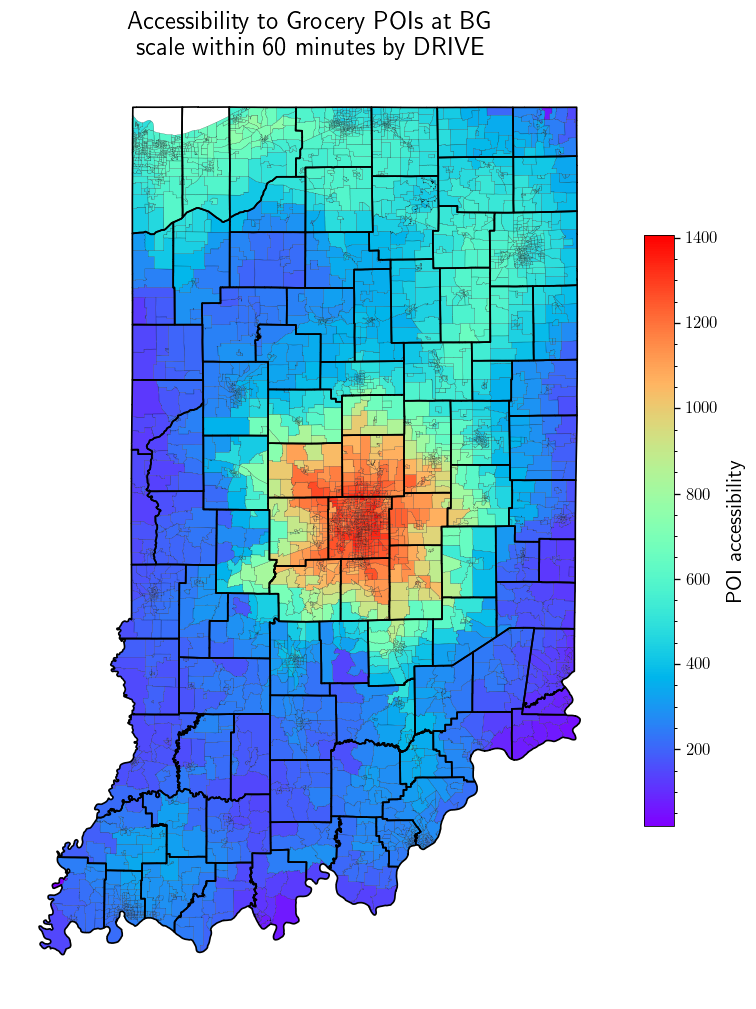

In [14]:
plot_map_poi_access('BG', 'DRIVE', 60, 'Grocery', source_popu=False) # t=0:09

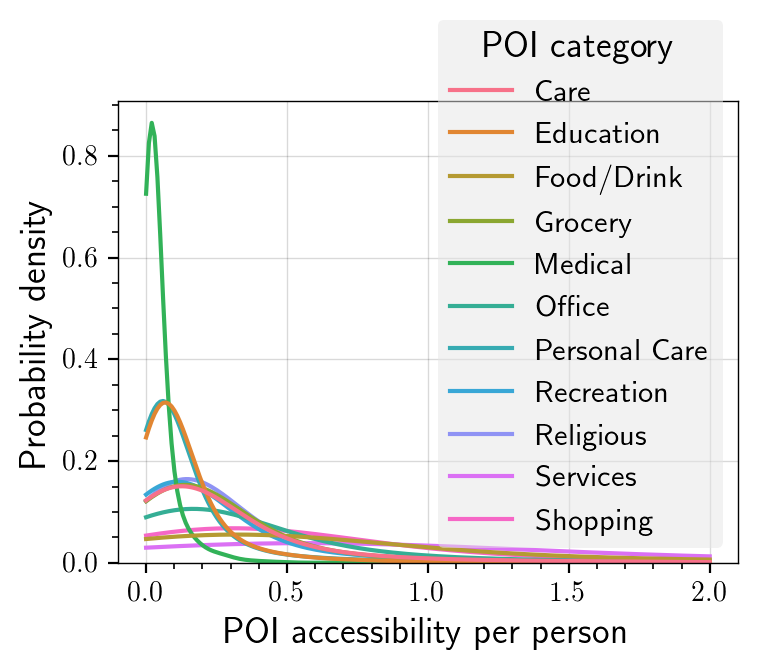

In [22]:
ax = U.plot(size=(4, 3), dpi=200)
title='Distribution of accessibility by POI kind'
sns.kdeplot(xs, x='access', hue='poi_kind', ax=ax, clip=(0, 2))
ax = U.plot(ax, xlab='POI accessibility per person', ylab='Probability density')
ax.get_legend().set_title('POI category');

In [23]:
# indy_cnty = cnty[cnty.name.isin(('Marion','Hamilton','Hendricks','Johnson','Madison','Hancock','Morgan','Boone','Shelby','Putnam','Brown'))].disp()
indy_cnty = zones.query('name == "Marion"').to_crs(CRS_M).disp()

1 rows x 6 cols; Memory: 0.0 MiB; CRS: EPSG:3857


,geoid,name,aland,awater,geometry,scale
,<object>,<object>,<int64>,<int64>,<geometry>,<object>
86,18097,Marion,1026408097,17377675,"POLYGON ((-9609832.152039 4825262.090051, -960...",COUNTY


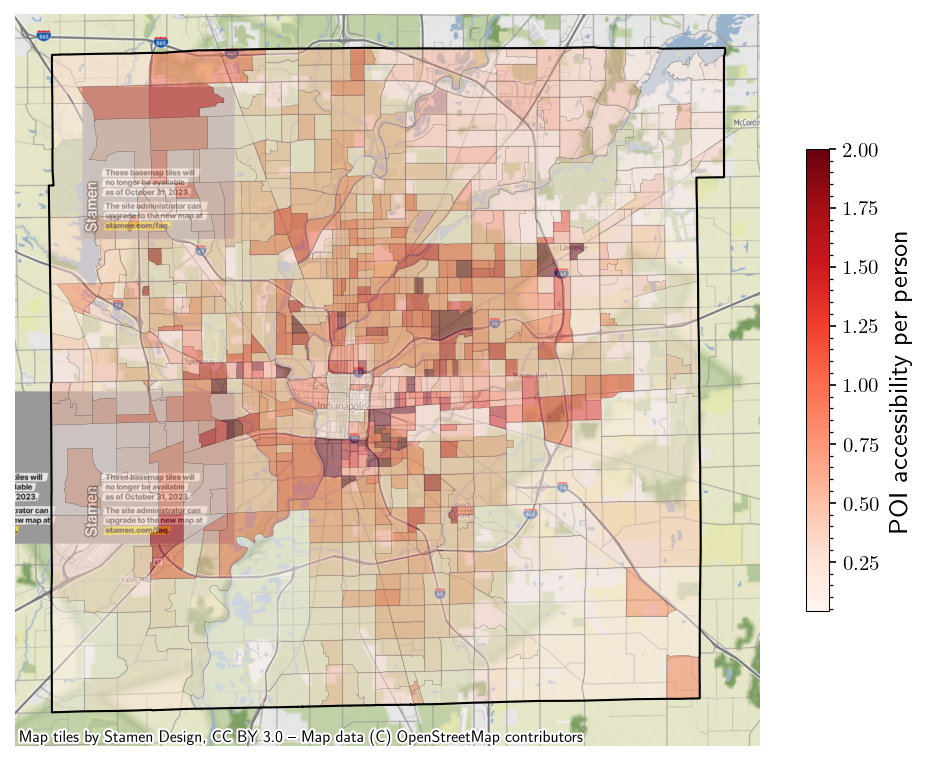

In [24]:
ax = U.plot(size=(8, 8), axoff=1)
indy_xs = (zones[['geoid','geometry']]
           .merge(xs.assign(cnty=xs.geoid.str[:5])
                  .query('poi_kind=="Grocery"')
                  .merge(indy_cnty['geoid'].rename('cnty')))
           .to_crs(CRS_M))
indy_xs.plot(ax=ax, column='access', cmap='Reds', legend=True,
            edgecolor='k', lw=0.1, vmax=2, alpha=0.5, legend_kwds=dict(
                shrink=0.5, label='POI accessibility per person'))
indy_cnty.plot(ax=ax, fc='none', ec='k', lw=1)
ctx.add_basemap(ax=ax, crs=CRS_M);

In [25]:
df = xs.merge(acs.assign(cnty=acs.geoid.str[:5]).merge(indy_cnty['geoid'].rename('cnty'))).query('poi_kind=="Grocery"')
# ax = U.plot(size=(5, 4), xlab='Median income (1,000 USD)', ylab='Access to grocery places')
# ax.scatter(df.inc_median/1e3, df.access.clip(0, 4), s=4, alpha=0.5);
df

,geoid,poi_kind,access,scale,popu,hh,pop_density,m_age,p_minor,p_senior,p_nonwhite,p_black,p_nocollege,m_income,p_pov,p_pov50,p_pov150,p_snap,p_unemploy,p_noinsurance,p_disabled,p_lowenglish,p_singleparent,p_renter,p_mobilehome,p_noveh,m_vehperhh,p_wfh,p_transit,p_altmode,cnty
3,180973101031,Grocery,0.181051,BG,2214.0,721.0,364.901570,38.2,0.158085,0.079042,0.438121,0.305330,NaN,NaN,NaN,NaN,NaN,0.040222,0.012942,NaN,NaN,NaN,0.000000,0.155274,0.0,NaN,NaN,0.054196,0.000924,0.046211,18097
14,180973101032,Grocery,0.940841,BG,882.0,268.0,489.420042,51.3,0.218821,0.221088,0.026077,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.075893,NaN,NaN,NaN,0.180328,0.000000,0.0,NaN,NaN,0.036232,0.000000,0.000000,18097
25,180973101033,Grocery,0.405616,BG,2046.0,708.0,901.612501,45.6,0.107527,0.172532,0.417889,0.313783,NaN,NaN,NaN,NaN,NaN,0.000000,0.009778,NaN,NaN,NaN,0.296703,0.154448,0.0,NaN,NaN,0.075404,0.000000,0.014563,18097
36,180973101034,Grocery,0.279189,BG,2736.0,994.0,792.006785,46.7,0.217471,0.167032,0.363670,0.325292,NaN,NaN,NaN,NaN,NaN,0.015091,0.056630,NaN,NaN,NaN,0.418605,0.128655,0.0,NaN,NaN,0.135432,0.000000,0.000000,18097
47,180973101041,Grocery,1.054043,BG,626.0,422.0,1105.554018,62.4,0.060703,0.348243,0.183706,0.183706,NaN,NaN,NaN,NaN,NaN,0.090047,0.000000,NaN,NaN,NaN,0.000000,0.442492,0.0,NaN,NaN,0.000000,0.060000,0.060000,18097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6900,180973909002,Grocery,1.765168,BG,473.0,252.0,4651.848779,36.9,0.000000,0.090909,0.192389,0.139535,NaN,NaN,NaN,NaN,NaN,0.000000,0.019512,NaN,NaN,NaN,0.000000,0.393235,0.0,NaN,NaN,0.012987,0.021053,0.128947,18097
6911,180973909003,Grocery,0.866137,BG,972.0,428.0,7130.184333,35.1,0.080247,0.062757,0.181070,0.119342,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,0.100000,0.312826,0.0,NaN,NaN,0.108183,0.006221,0.139969,18097
6922,180973910001,Grocery,0.319475,BG,2801.0,1541.0,6454.432919,26.7,0.020350,0.008925,0.251696,0.101035,NaN,NaN,NaN,NaN,NaN,0.031798,0.045455,NaN,NaN,NaN,1.000000,0.884819,0.0,NaN,NaN,0.013848,0.018556,0.332999,18097
6933,180973910002,Grocery,0.902609,BG,915.0,250.0,1235.751584,19.9,0.017486,0.000000,0.346448,0.049180,NaN,NaN,NaN,NaN,NaN,0.000000,0.044610,NaN,NaN,NaN,0.000000,1.000000,0.0,NaN,NaN,0.041485,0.056948,0.624146,18097
